### Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
X_data = pd.read_csv('dataset/fitur.csv')
X = X_data.values
X

array([[0.        , 0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.        , 0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.        , 0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.6969697 , 0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.6969697 , 0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.6969697 , 0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [3]:
y_data = pd.read_csv('dataset/target.csv')
y = y_data.values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
X_test = pd.DataFrame(X_test, columns=X_data.columns)
y_test = pd.DataFrame(y_test, columns=y_data.columns)
X_test.to_csv('dataset/X_test.csv', index=False)
y_test.to_csv('dataset/y_test.csv', index=False)

### Modeling

##### Inisialisasi bobot dan bias

In [6]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(4)])
        else:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(hidden_neuron[i-1])])
        bias.append([random.uniform(0, 1) for _ in range(hidden_neuron[i])])
    bobot_output = [random.uniform(0, 1) for _ in range(hidden_neuron[-1])]
    bias_output = random.uniform(0, 1)
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [7]:
def aktivasiX(activ, x): 
    # aktivasi relu
    if activ == 'relu':
        if x >= 0:
            return x
        else:
            return 0
    # aktivasi sigmoid
    elif activ == 'sigmoid':
        return 1 / (1 + math.exp(-x))
    # aktivasi softmax
    elif activ == 'softmax':
        return 1
    # aktivasi tanh
    else:
        return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

def turunanaktivasiX(activ, x): 
    # turunan aktivasi relu
    if activ == 'relu':
        if x > 0:
            return 1
        else:
            return 0
    # turunan aktivasi sigmoid
    elif activ == 'sigmoid':
        sig = 1 / (1 + math.exp(-x))
        return sig * (1 - sig)
    # turunan aktivasi softmax
    elif activ == 'softmax':
        return 0
    # turunan aktivasi tanh
    else:
        tan = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        return 1 - (tan) ** 2

##### Fungsi Training

In [8]:
def ann(epochs, hidden_layer, hidden_neuron, activation, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    konstan = 0
    mse_epoch = []
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(aktivasiX(activation, sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = aktivasiX(activation, sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunanaktivasiX(activation, prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        mse_epoch.append(mse)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
        elif mse == best_mse:
            konstan +=1
            if konstan == 3:
                print("MSE stabil, PELATIHAN DIHENTIKAN")
                break
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output, mse_epoch

##### Training + Tuning

In [9]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2]
    neuron_values = [2, 3, 4]
    aktivasi_values = ['relu', 'sigmoid', 'tanh']
    lr_values = [0.0001, 0.001]
    epoch_values = [100, 200]

    hidden_layer_list = []
    hidden_neuron_list = []
    aktivasi_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    mse_epoch_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for aktivasi in aktivasi_values:
                for lr in lr_values:
                    for epoch in epoch_values:
                        i += 1
                        print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, AKTIVASI={aktivasi}, LR={lr}, EPOCH={epoch}")
                        mse, bobot, bias, bobot_output, bias_output, mse_epoch = ann(epoch, hidden_layer, tuple(hidden_neuron_combination), aktivasi, lr, X_train, y_train)
                        hidden_layer_list.append(hidden_layer)
                        hidden_neuron_list.append(tuple(hidden_neuron_combination))
                        aktivasi_list.append(aktivasi)
                        lr_list.append(lr)
                        epoch_list.append(epoch)
                        mse_list.append(mse)
                        bobot_list.append(bobot)
                        bias_list.append(bias)
                        bobot_output_list.append(bobot_output)
                        bias_output_list.append(bias_output)
                        mse_epoch_list.append(mse_epoch)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'aktivasi': aktivasi_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list,
        'mse_list': mse_epoch_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [10]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(2,), AKTIVASI=relu, LR=0.0001, EPOCH=100
Epoch 1, MSE: 1.8252634267898935
Epoch 2, MSE: 0.7900289501994316
Epoch 3, MSE: 0.348271370161026
Epoch 4, MSE: 0.15774201008251174
Epoch 5, MSE: 0.07451669275214728
Epoch 6, MSE: 0.037544149139357275
Epoch 7, MSE: 0.020740516630359886
Epoch 8, MSE: 0.012871846511792842
Epoch 9, MSE: 0.009048383099667772
Epoch 10, MSE: 0.007108719174305493
Epoch 11, MSE: 0.006078548859238799
Epoch 12, MSE: 0.005506286142651613
Epoch 13, MSE: 0.0051755672127641004
Epoch 14, MSE: 0.004977973956771026
Epoch 15, MSE: 0.004856916237442792
Epoch 16, MSE: 0.004781318207680872
Epoch 17, MSE: 0.004733480010234128
Epoch 18, MSE: 0.004702931330776991
Epoch 19, MSE: 0.004683303187826449
Epoch 20, MSE: 0.00467063993507964
Epoch 21, MSE: 0.004662447983406687
Epoch 22, MSE: 0.004657139109243279
Epoch 23, MSE: 0.004653694629722996
Epoch 24, MSE: 0.004651458096309406
Epoch 25, MSE: 0.004650005172682848
Epoch 26, MSE: 0.00464906100169

##### Visualisasi hasil tuning

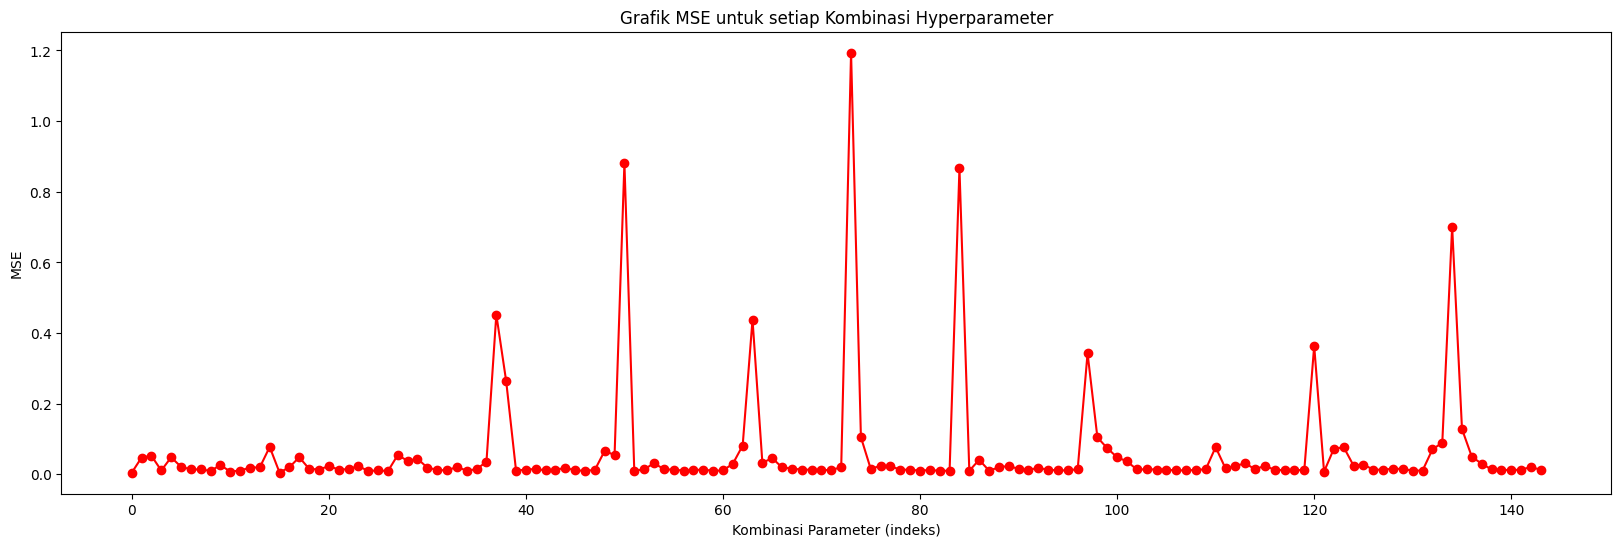

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [12]:
tuning.to_csv('hasiltuning/hasiltuning.csv', index=False)
tuning.to_excel('hasiltuning/hasiltuning.xlsx', index=False)

In [13]:
tuning

,hidden_layer,hidden_neuron,aktivasi,lr,epoch,mse,bobot,bias,bobot_output,bias_output,mse_list
0,1,"(2,)",relu,0.0001,100,0.004647,"[[[-0.3098401122445924, 0.3814742009731637], [...","[[0.41770561461960476, -0.3160343507099042]]","[0.499480544276838, 0.32014824725020186]",0.374371,"[1.8252634267898935, 0.7900289501994316, 0.348..."
1,1,"(2,)",relu,0.0001,200,0.047708,"[[[-0.19697657345155606, -0.44575297621033105]...","[[0.5023398935575754, -1.0441840095798156]]","[0.9193960696103054, 0.7812727020502632]",0.895480,"[13.363339896541497, 0.04883839581601361, 0.04..."
2,1,"(2,)",relu,0.0010,100,0.052485,"[[[-4.903490529354346, -1.0764824706970069], [...","[[0.8103496089334337, -2.241561474412262]]","[0.9698847300113459, 0.2674593543740801]",0.500738,"[4.332502372973904, 0.0635963801645697, 0.0634..."
3,1,"(2,)",relu,0.0010,200,0.011031,"[[[-3.8779108364510573, -2.72649434775766], [-...","[[0.7242650343950839, -4.158399748287819]]","[0.6642022747999236, 0.41431577292999794]",0.685237,"[5.056697186851262, 0.011777388930260865, 0.01..."
4,1,"(2,)",sigmoid,0.0001,100,0.048263,"[[[0.7942046012699949, 0.0836560909164048], [0...","[[0.1960893340554638, 0.34149975022755363]]","[0.7951085048289629, 0.8310361877457294]",0.976747,"[0.053993781789340944, 0.05394743079180646, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
139,2,"(4, 4)",sigmoid,0.0010,200,0.012857,"[[[0.4855992620101374, 0.2083719711252322, 0.8...","[[0.39519769789969206, 0.41853726930294965, 0....","[0.8505423079860022, 0.8765099006278528, 0.671...",0.966330,"[0.08598366886800504, 0.08540885046724157, 0.0..."
140,2,"(4, 4)",tanh,0.0001,100,0.011989,"[[[0.010673842938404756, 0.1711642889724345, 0...","[[0.42529227099950573, 0.6416521508416995, 0.6...","[0.2880624885515357, 0.23407864563680822, 0.49...",0.316304,"[0.046368886816909635, 0.04613913096970647, 0...."
141,2,"(4, 4)",tanh,0.0001,200,0.013339,"[[[0.5888326895607654, 0.283694599858329, 0.05...","[[0.7294991021282342, 0.49169219902660577, 0.2...","[0.15477019627244215, 0.5085019737569394, 0.19...",0.589441,"[0.05082817639649249, 0.05033069514208361, 0.0..."
142,2,"(4, 4)",tanh,0.0010,100,0.020749,"[[[-0.40980347286448965, -0.16148785537916277,...","[[0.2605852643702664, 0.764458649135174, 0.348...","[0.1500491741730867, 0.8564413171459523, 0.709...",0.308765,"[0.0892185496610021, 0.08714694759670888, 0.07..."


In [14]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]
best_mse_list_global = tuning['mse_list'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)
print("Best MSE List:", best_mse_list_global)

Best Index: 0
Best Hidden Layer: 1
Best Hidden Neuron: (2,)
Best Learning Rate: 0.0001
Best Epoch: 100
Best MSE: 0.004647306929561859
Best Bobot: [[[np.float64(-0.3098401122445924), np.float64(0.3814742009731637)], [np.float64(-0.05237008023047972), np.float64(0.2080316722180022)], [np.float64(0.28318618535255174), np.float64(0.4682242021891708)], [np.float64(0.028475214765678884), np.float64(0.29743736301177187)]]]
Best Bias: [[0.41770561461960476, np.float64(-0.3160343507099042)]]
Best Bobot Output: [np.float64(0.499480544276838), np.float64(0.32014824725020186)]
Best Bias Output: 0.3743712918686607
Best MSE List: [np.float64(1.8252634267898935), np.float64(0.7900289501994316), np.float64(0.348271370161026), np.float64(0.15774201008251174), np.float64(0.07451669275214728), np.float64(0.037544149139357275), np.float64(0.020740516630359886), np.float64(0.012871846511792842), np.float64(0.009048383099667772), np.float64(0.007108719174305493), np.float64(0.006078548859238799), np.float64

##### Visualisasi MSE per Iterasi Kombinasi Terbaik

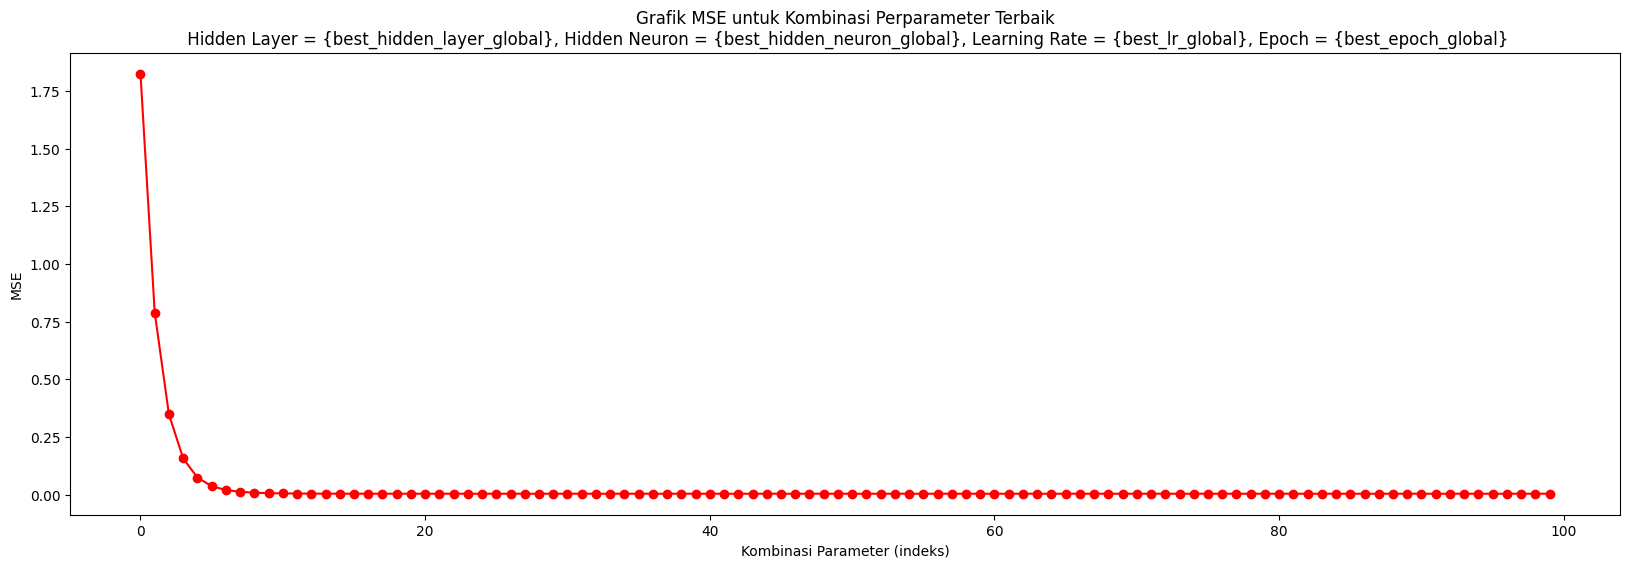

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(best_mse_list_global)), best_mse_list_global, marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk Kombinasi Perparameter Terbaik\n Hidden Layer = {best_hidden_layer_global}, Hidden Neuron = {best_hidden_neuron_global}, Learning Rate = {best_lr_global}, Epoch = {best_epoch_global}')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()